# Lecture d'une dicom :

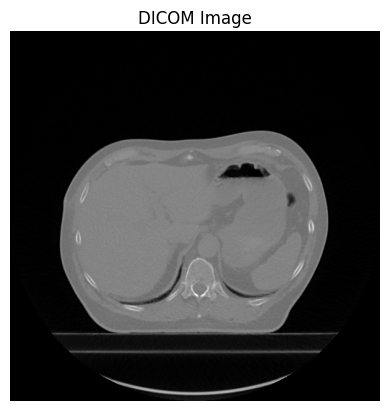

In [1]:
import pydicom
import matplotlib.pyplot as plt

# Chargement du fichier DICOM
file_path = '1-024.dcm'
dicom_data = pydicom.dcmread(file_path)

# Extraction de l'image des données DICOM
image = dicom_data.pixel_array

# Affichage de l'image
plt.imshow(image, cmap='gray')  # Utilisation d'une colormap en niveaux de gris
plt.axis('off')  # Désactivation des axes pour une meilleure visualisation
plt.title('DICOM Image')
plt.show()

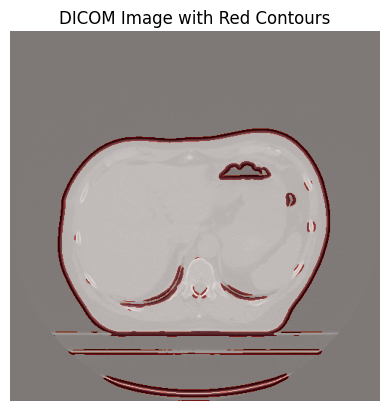

In [2]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter, sobel

# Chargement du fichier DICOM
file_path = '1-024.dcm'
dicom_data = pydicom.dcmread(file_path)

# Extraction de l'image des données DICOM
image = dicom_data.pixel_array

# Lissage de l'image pour réduire le bruit avant la détection des contours
smoothed_image = gaussian_filter(image, sigma=2)

# Calcul du gradient de l'image lissée
sx = sobel(smoothed_image, axis=0, mode='constant')
sy = sobel(smoothed_image, axis=1, mode='constant')
sobel_mag = np.hypot(sx, sy)

# Seuil de détection du contour
threshold = np.percentile(sobel_mag, 95)  # Ajuster selon la qualité du contour souhaitée
contour_mask = sobel_mag > threshold

# Affichage de l'image avec les contours en rouge
plt.imshow(image, cmap='gray')
plt.imshow(contour_mask, cmap='Reds', alpha=0.5)  # La transparence alpha permet de voir l'image sous les contours
plt.axis('off')
plt.title('DICOM Image with Red Contours')
plt.show()

In [6]:
import os
import pydicom
import numpy as np
from scipy.ndimage import gaussian_filter, sobel
from rt_utils import RTStructBuilder

# Fonction pour détecter les contours d'une image DICOM
def detect_contours(image):
    smoothed_image = gaussian_filter(image, sigma=2)
    sx = sobel(smoothed_image, axis=0, mode='constant')
    sy = sobel(smoothed_image, axis=1, mode='constant')
    sobel_mag = np.hypot(sx, sy)
    threshold = np.percentile(sobel_mag, 95)
    return sobel_mag > threshold

# Chemin vers le dossier contenant les fichiers DICOM
dicom_folder_path = '/home/romain/Vidéos/mbiaDataDownloads/manifest-1557326747206/LCTSC/LCTSC-Test-S1-101/versionSansRT/1.3.6.1.4.1.14519.5.2.1.7014.4598.492964872630309412859177308186/1.3.6.1.4.1.14519.5.2.1.7014.4598.106943890850011666503487579262'
dicom_files = [f for f in os.listdir(dicom_folder_path) if f.endswith('.dcm')]

# Création du RTStruct
rtstruct = RTStructBuilder.create_new(dicom_series_path=dicom_folder_path)

# Initialisation du masque 3D basé sur le nombre de fichiers et la taille des images
example_dicom = pydicom.dcmread(os.path.join(dicom_folder_path, dicom_files[0]))
num_slices = len(dicom_files)
mask_shape = (example_dicom.Rows, example_dicom.Columns, num_slices)
full_mask = np.zeros(mask_shape, dtype=bool)

# Traitement de chaque fichier DICOM
for i, file_name in enumerate(dicom_files):
    dicom_path = os.path.join(dicom_folder_path, file_name)
    dicom_data = pydicom.dcmread(dicom_path)
    image = dicom_data.pixel_array
    contour_mask = detect_contours(image)
    full_mask[:, :, i] = contour_mask  # Remplissage du masque 3D

# Ajouter la ROI au RTStruct
rtstruct.add_roi(mask=full_mask, color=[255, 0, 0], name='Brain Contours')

# Enregistrement du fichier RTStruct
rtstruct.save('output_rtstruct.dcm')

Writing file to output_rtstruct.dcm


In [7]:
import os
import pydicom
import numpy as np
from scipy.ndimage import gaussian_filter, sobel
from rt_utils import RTStructBuilder

# pour détecter les contours d'une image DICOM
def detect_contours(image):
    # lissage de l'image pour réduire le bruit avant la détection des contours
    smoothed_image = gaussian_filter(image, sigma=2)
    
    # calcul du gradient de l'image lissée
    sx = sobel(smoothed_image, axis=0, mode='constant')
    sy = sobel(smoothed_image, axis=1, mode='constant')
    sobel_mag = np.hypot(sx, sy)
    
    # seuil de détection du contour
    threshold = np.percentile(sobel_mag, 95)
    
    # matrice boolenne
    return sobel_mag > threshold

# path vers le dossier des dicoms
dicom_folder_path = '/home/romain/Vidéos/mbiaDataDownloads/manifest-1557326747206/LCTSC/LCTSC-Test-S1-101/versionSansRT/1.3.6.1.4.1.14519.5.2.1.7014.4598.492964872630309412859177308186/1.3.6.1.4.1.14519.5.2.1.7014.4598.106943890850011666503487579262'
dicom_files = [f for f in os.listdir(dicom_folder_path) if f.endswith('.dcm')]

# lire et trier les fichiers dicoms par 'InstanceNumber' #si c pas fait, les rois corespondront pas aux dicoms
dicom_files = [pydicom.dcmread(os.path.join(dicom_folder_path, f)) for f in dicom_files]
dicom_files.sort(key=lambda x: x.InstanceNumber)

# creation du rtstruct vierge
rtstruct = RTStructBuilder.create_new(dicom_series_path=dicom_folder_path)

# init du masque 3D basé sur le nombre de fichiers et la taille des images
num_slices = len(dicom_files)
mask_shape = (dicom_files[0].Rows, dicom_files[0].Columns, num_slices)
full_mask = np.zeros(mask_shape, dtype=bool)

# pour chaque fichier dicom :
for i, dicom_data in enumerate(dicom_files):
    # calculer le masque correspondant et le mettre dans le masque 3D
    image = dicom_data.pixel_array
    contour_mask = detect_contours(image)
    full_mask[:, :, i] = contour_mask  # Remplissage du masque 3D

# ajouter le masque au fichier RTStruct
rtstruct.add_roi(mask=full_mask, color=[255, 0, 0], name='Brain Contours')

# sauvegarde du fichier rtstruct
rtstruct.save('output_rtstruct.dcm')

Writing file to output_rtstruct.dcm


In [ ]:
import os
import sys
from typing import List
sys.path.append(os.path.abspath('./rt-utils'))
import pydicom
import numpy as np
from scipy.ndimage import gaussian_filter, sobel
from rt_utils import RTStructBuilder

# pour détecter les contours d'une image DICOM
def detect_contours(image):
    """
    Si tu ne comprends rien :  
    Un filtre de Sobel est appliqué pour trouver les gradients dans les deux directions x et y. 
    Le gradient total (magnitude) est calculé et un seuil est appliqué pour obtenir un masque de contour.
    """
    
    # lissage de l'image pour réduire le bruit avant la détection des contours
    smoothed_image = gaussian_filter(image, sigma=2)
    
    # calcul du gradient de l'image lissée
    sx = sobel(smoothed_image, axis=0, mode='constant')
    sy = sobel(smoothed_image, axis=1, mode='constant')
    sobel_mag = np.hypot(sx, sy)
    
    # seuil de détection du contour
    threshold = np.percentile(sobel_mag, 95)
    
    # matrice boolenne
    return sobel_mag > threshold

# pour créer un RTStruct à partir d'images dicoms, il fait un simple contour car c'est un mock 
def mock_perform_rtstruct(dicom_datasets: List[pydicom.Dataset]):
    dicom_datasets.sort(key=lambda x: x.InstanceNumber if 'InstanceNumber' in dir(x) else 0)
    # creation du rtstruct vierge
    rtstruct = RTStructBuilder.create_new_from_memory(dicom_datasets)

    # init du masque 3D basé sur le nombre de fichiers et la taille des images
    num_slices = len(dicom_files)
    mask_shape = (dicom_files[0].Rows, dicom_files[0].Columns, num_slices)
    full_mask = np.zeros(mask_shape, dtype=bool)

    # pour chaque fichier dicom :
    for i, dicom_data in enumerate(dicom_files):
        # calculer le masque correspondant et le mettre dans le masque 3D
        image = dicom_data.pixel_array
        contour_mask = detect_contours(image)
        full_mask[:, :, i] = contour_mask  # Remplissage du masque 3D

    # ajouter le masque au fichier RTStruct
    rtstruct.add_roi(mask=full_mask, color=[255, 0, 0], name='Brain Contours')

    # sauvegarde du fichier rtstruct
    return rtstruct

In [ ]:
from pydicom.dataset import Dataset
from typing import List

def load_dicom_datasets(dicom_folder_path: str) -> List[Dataset]:
    """
    Charge tous les fichiers DICOM d'un dossier donné en datasets pydicom.
    """
    dicom_datasets = []
    for filename in os.listdir(dicom_folder_path):
        if filename.endswith('.dcm'):
            file_path = os.path.join(dicom_folder_path, filename)
            try:
                ds = pydicom.dcmread(file_path)
                dicom_datasets.append(ds)
            except Exception as e:
                print(f"Erreur lors de la lecture du fichier DICOM {filename}: {e}")
                continue  # ou lever une exception selon les besoins de votre application

    if not dicom_datasets:
        raise Exception("Aucun fichier DICOM valide trouvé dans le dossier spécifié.")

    return dicom_datasets

# Utilisation de la fonction
dicom_folder_path232 = '/home/romain/Vidéos/mbiaDataDownloads/manifest-1557326747206/LCTSC/LCTSC-Test-S1-101/versionSansRT/1.3.6.1.4.1.14519.5.2.1.7014.4598.492964872630309412859177308186/1.3.6.1.4.1.14519.5.2.1.7014.4598.106943890850011666503487579262'
dicom_files = load_dicom_datasets(dicom_folder_path232)

# Génération du RTStruct
rtstruct = mock_perform_rtstruct(dicom_files)

# Sauvegarde du fichier RTStruct dans le répertoire courant
output_path = os.path.join(os.getcwd(), 'output_rtstruct.dcm')
rtstruct.save(output_path)
print(f'RTStruct saved to {output_path}')

Writing file to /home/romain/Documents/P_R_O_J_E_C_T_S/projetIRM/BrainMetaSegmentatorUI-Back/output_rtstruct.dcm
RTStruct saved to /home/romain/Documents/P_R_O_J_E_C_T_S/projetIRM/BrainMetaSegmentatorUI-Back/output_rtstruct.dcm
